# **Image Classification with Convolutional Neural Networks (CNNs)**

# **Building a Convolutional Neural Network with Keras**

In [ ]:
import numpy as np
import tensorflow as tf
tf.__version__

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import imageio

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

'2.8.2'

**Data Acquisition and ImageDataGenerator**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#File path to the folder containin images
train_dir = os.path.join('/content/spectrograms-150/Train')
validation_dir = os.path.join('/content/spectrograms-150/Validation')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

Found 33128 images belonging to 2 classes.
Found 6780 images belonging to 2 classes.


**Building the Model**

In [ ]:
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Second convolution layer 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    

    # Third convolution layer  
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

  # Fourth convolution layer  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),


    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(8, activation='relu',use_bias=True),


    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid',activity_regularizer=regularizers.L1(0.001))   

])


**Model Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       2

**Optimizer Implementation and model training/validation**

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)]) 

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99): 
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=500,
      verbose=1,
      validation_data = validation_generator,
      callbacks = [callbacks,checkpoint]
) 

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.4914 - sensitivity_at_specificity: 0.4606 - specificity_at_sensitivity: 0.4660 - recall: 0.7713 - precision: 0.4947
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to ECG_Spectrogram_Model.h5
10/10 [==============================] - 17s 222ms/step - loss: 0.7020 - accuracy: 0.4914 - sensitivity_at_specificity: 0.4606 - specificity_at_sensitivity: 0.4660 - recall: 0.7713 - precision: 0.4947 - val_loss: 0.6937 - val_accuracy: 0.4875 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5027 - sensitivity_at_specificity: 0.0827 - specificity_at_sensitivity: 0.0636 - recall: 0.1110 - precision: 0.4947
Epoch 2: val_accuracy improved from 0.48750 to 0.50781, saving model to ECG_Spectrogram_Model.h5
10/10 [====

**Performance Metrics**

In [ ]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",max(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

Training Accuracy:  0.9683593511581421
Validation Accuracy:  0.6742187738418579
Validation Specificity:  0.881538450717926
Validation Sensitivity:  0.9226973652839661
Validation Recall:  1.0
Validation Precision:  0.6264674663543701
Validation Loss:  0.5551823973655701


**Accuracy Graph**

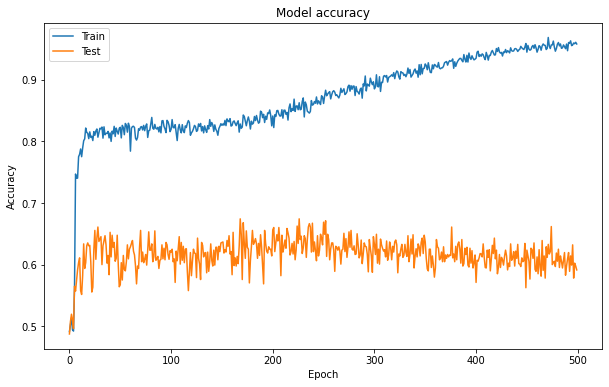

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Loss Graph**

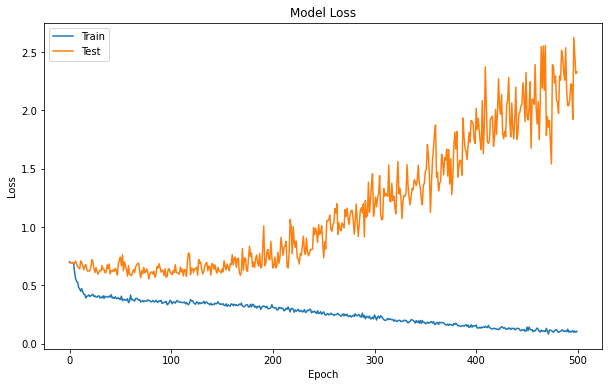

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()